In [14]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [15]:
# Reading the data
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [16]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [17]:
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')


In [18]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [19]:
# Image Reading and Resizing.
IMAGE_SIZE = 64
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [01:36<00:00, 103.86it/s]


In [20]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
X=X[1:]
print(X.shape)
y = np.array(skin_df['cell_type_idx'])
y=y[1:]

(10014, 64, 64, 3)


In [21]:
# Splitting the data
from sklearn.model_selection import train_test_split

train_df ,test_df,train_labl ,test_labl = train_test_split(X,y,test_size=0.2,random_state=42)



In [22]:
test_labl.shape

(2003,)

In [23]:
train_labl.shape

(8011,)

In [24]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=(64,64,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=4, max_value=128, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=4, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(7, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-5])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
#importing random search
from kerastuner import RandomSearch
#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 100)
# search best parameter
tuner.search(train_df,train_labl,epochs=10,validation_data=(test_df,test_labl))

Trial 101 Complete [00h 00m 42s]
val_accuracy: 0.7029455900192261

Best val_accuracy So Far: 0.7269096374511719
Total elapsed time: 00h 46m 07s


In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 1e-05], 'ordered': True}


In [27]:
model=tuner.get_best_models(num_models=1)[0]
#summary of best model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 112)       8512      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 112)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 112)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        179264    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

In [28]:
from keras.utils.vis_utils import plot_model

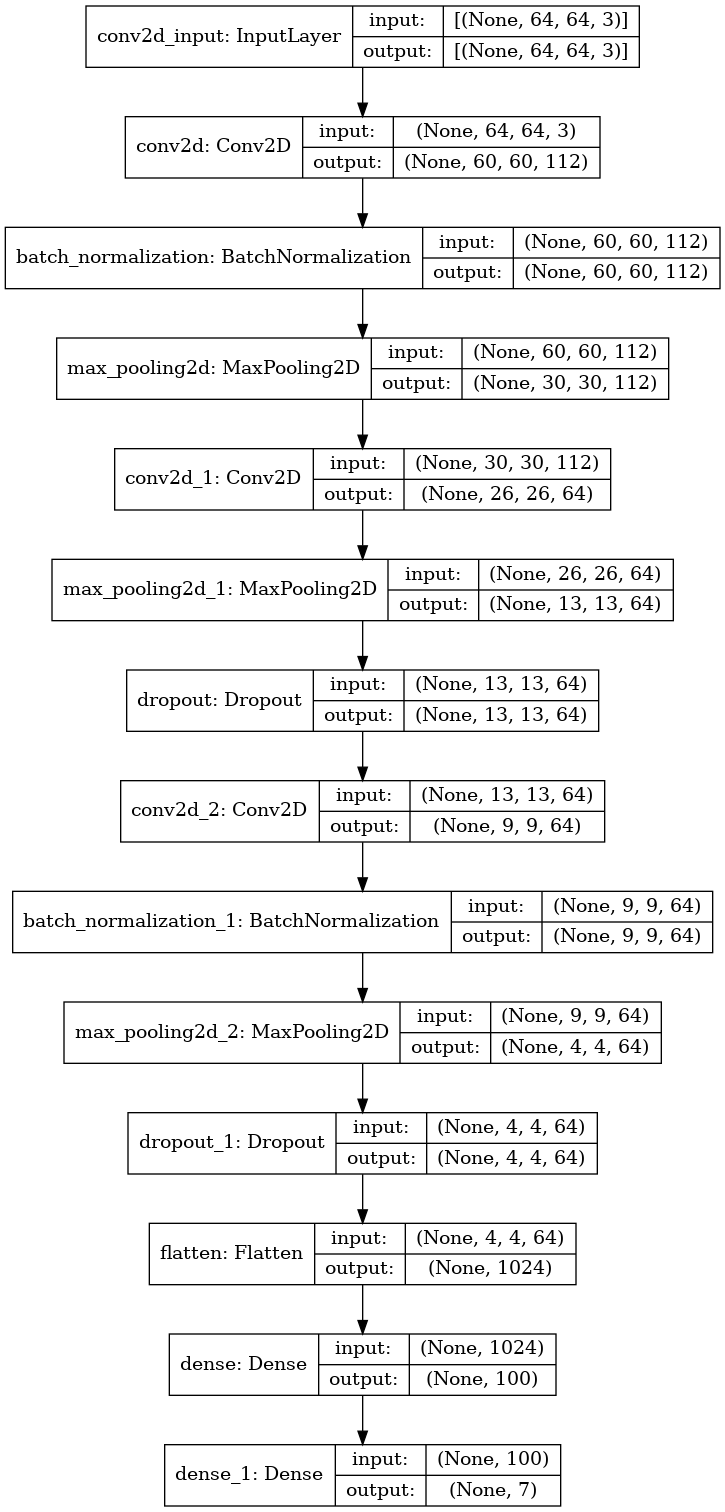

In [29]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# !pip install visualkeras


In [31]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 64
conv_2_kernel: 5
dense_1_units: 100
learning_rate: 1e-05
Score: 0.7269096374511719
Trial summary
Hyperparameters:
conv_1_filter: 96
conv_1_kernel: 5
conv_2_filter: 96
conv_2_kernel: 5
dense_1_units: 68
learning_rate: 1e-05
Score: 0.7244133949279785
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 112
conv_2_kernel: 5
dense_1_units: 84
learning_rate: 1e-05
Score: 0.7234148979187012
Trial summary
Hyperparameters:
conv_1_filter: 64
conv_1_kernel: 5
conv_2_filter: 112
conv_2_kernel: 3
dense_1_units: 116
learning_rate: 1e-05
Score: 0.7219171524047852
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
conv_2_filter: 112
conv_2_kernel: 5
dense_1_units: 100
learning_rate: 1e-05
Score: 0.717923104763031
Trial summary
Hyperparameters:
conv_1_filter: 

In [32]:
checkpoint_filepath = "weights.best_tuner.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [33]:
history=model.fit(train_df,train_labl,
          epochs=100,
          validation_split=0.20,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/100
201/201 [==============================] - 3s 11ms/step - loss: 0.8428 - accuracy: 0.6982 - val_loss: 0.7529 - val_accuracy: 0.7293

Epoch 00001: val_accuracy improved from -inf to 0.72926, saving model to weights.best_tuner.hdf5
Epoch 2/100
201/201 [==============================] - 2s 10ms/step - loss: 0.8281 - accuracy: 0.7054 - val_loss: 0.7536 - val_accuracy: 0.7355

Epoch 00002: val_accuracy improved from 0.72926 to 0.73550, saving model to weights.best_tuner.hdf5
Epoch 3/100
201/201 [==============================] - 2s 9ms/step - loss: 0.8172 - accuracy: 0.7021 - val_loss: 0.7462 - val_accuracy: 0.7480

Epoch 00003: val_accuracy improved from 0.73550 to 0.74797, saving model to weights.best_tuner.hdf5
Epoch 4/100
201/201 [==============================] - 2s 9ms/step - loss: 0.8018 - accuracy: 0.7037 - val_loss: 0.7411 - val_accuracy: 0.7517

Epoch 00004: val_accuracy improved from 0.74797 to 0.75172, saving model to weights.best_tuner.hdf5
Epoch 5/100
201/201 [====

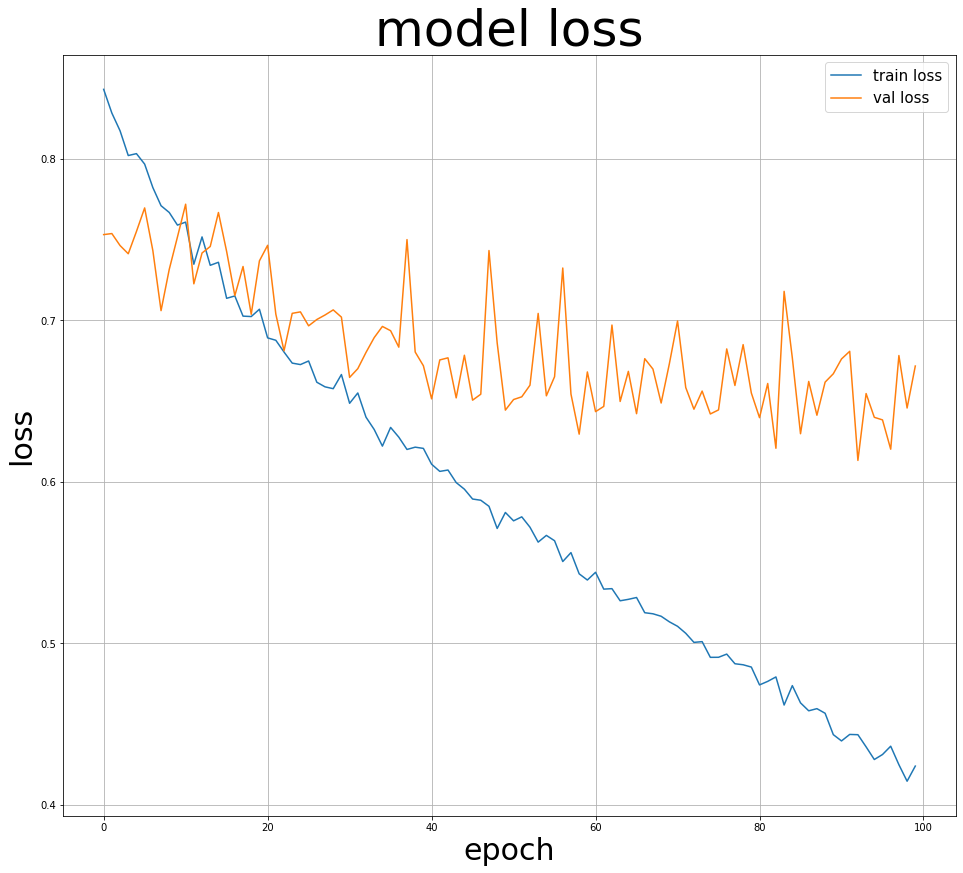

In [34]:
plt.rcParams["figure.figsize"] = (16,14)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')




plt.title('model loss',size=50)
plt.ylabel('loss',size=30)
plt.xlabel('epoch',size=30)
plt.legend(prop={'size': 15})
plt.grid()

plt.savefig('LossVal_loss2222222.jpg')

plt.show()



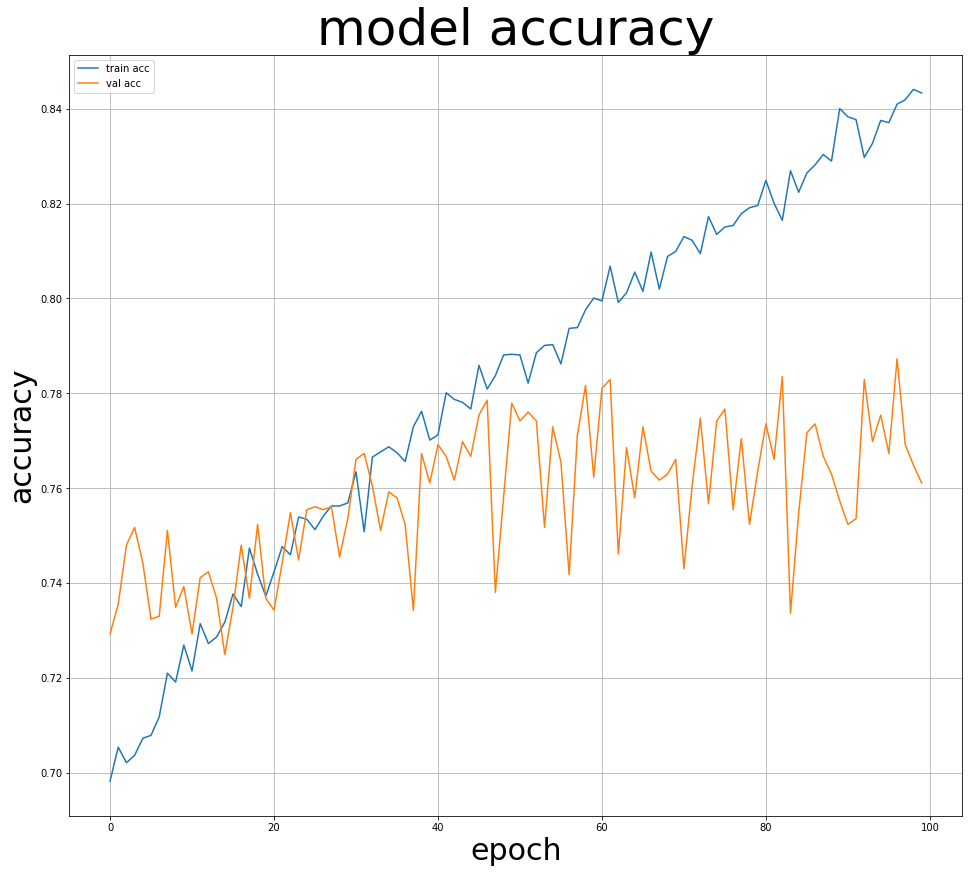

In [35]:
plt.rcParams["figure.figsize"] = (16,14)

plt.rcParams["figure.figsize"] = (16,14)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')


plt.title('model accuracy',size=50)
plt.ylabel('accuracy',size=30)
plt.xlabel('epoch',size=30)
plt.legend(prop={'size': 15})
plt.grid()
plt.legend()
plt.savefig("acc222.jpg")

plt.show()

In [36]:
pred = model.predict(test_df)
pred = np.argmax(pred,axis=1)


In [37]:
from sklearn.metrics import classification_report

print(classification_report(test_labl,pred))

              precision    recall  f1-score   support

           0       0.39      0.49      0.44        81
           1       0.40      0.72      0.52        90
           2       0.52      0.60      0.56       228
           3       0.88      0.25      0.39        28
           4       0.91      0.85      0.88      1328
           5       0.52      0.43      0.47       226
           6       0.58      0.86      0.69        22

    accuracy                           0.75      2003
   macro avg       0.60      0.60      0.56      2003
weighted avg       0.77      0.75      0.75      2003



In [38]:
import sklearn.metrics as metrics

cf_matrix= metrics.confusion_matrix(y_true=test_labl, y_pred=pred)  # shape=(12, 12)
print(cf_matrix)

[[  40   24    9    0    5    3    0]
 [  12   65    4    0    5    4    0]
 [  19   24  137    0   38   10    0]
 [   5    8    2    7    6    0    0]
 [  12   31   69    1 1133   71   11]
 [  12    9   42    0   63   97    3]
 [   2    0    0    0    1    0   19]]


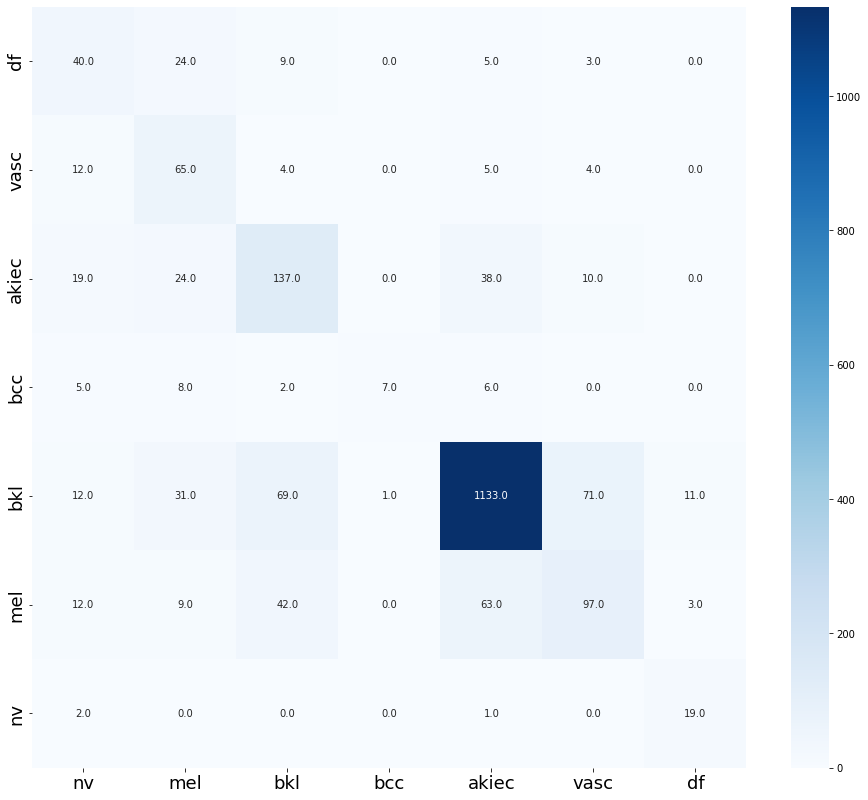

In [39]:
plt.rcParams["figure.figsize"] = (16,14)

import seaborn as sns
ax=sns.heatmap(cf_matrix, annot=True, fmt=".1f",cmap='Blues')

ax.xaxis.set_ticklabels(['nv','mel','bkl','bcc',"akiec","vasc","df"],size=18)
ax.yaxis.set_ticklabels(['df','vasc',"akiec","bcc","bkl","mel","nv"],size=18)

plt.savefig("tuner_cm.jpg")

plt.show()

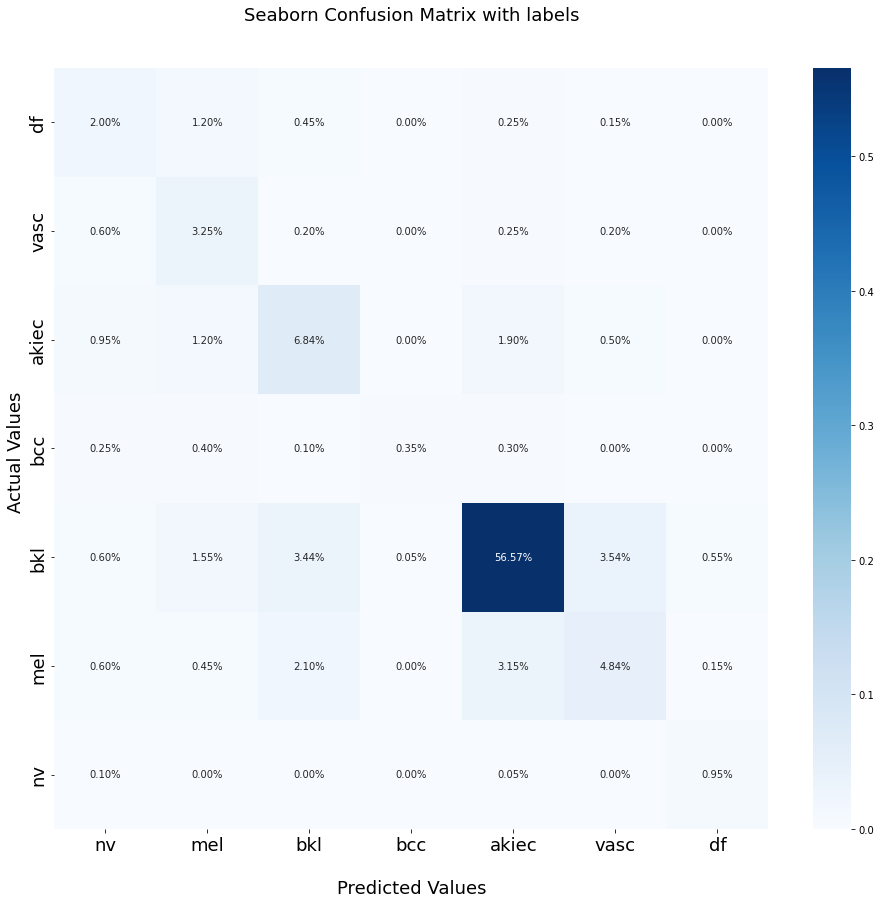

In [40]:
plt.rcParams["figure.figsize"] = (16,14)

ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n',size=18);
ax.set_xlabel('\nPredicted Values',size=18)
ax.set_ylabel('Actual Values ',size=18);


ax.xaxis.set_ticklabels(['nv','mel','bkl','bcc',"akiec","vasc","df"],size=18)
ax.yaxis.set_ticklabels(['df','vasc',"akiec","bcc","bkl","mel","nv"],size=18)
plt.savefig("tuner_cm2.jpg")

plt.show()